In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from eofs.xarray import Eof
from dust import map_terrain_china
from dust.plot.plotting import mpl_base_map_plot_xr, plot_log_anomaly
import cartopy.crs as ccrs
import numpy as np
from thesis_toolbox.utils import get_locations_CLP,read_depostion_datasets
import matplotlib as mpl
from scipy import signal
from thesis_toolbox.plot.tools import add_letter
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter,AutoMinorLocator
%matplotlib inline

## EOF analysis emissions


In [2]:
ems_dset = xr.open_dataset('../../data/data/results/model_results/intermediate_results/emission_flux.china.MAM.1999-2019.nc')

In [3]:
ems_dset_y = ems_dset.resample(time='Y').sum()
ems_dset_y = ems_dset_y.assign(Emissions_detrended = (['time','lat','lon'],signal.detrend(ems_dset_y.Emission,axis=0)))

In [4]:
coslat = np.cos(np.deg2rad(ems_dset_y['lat'].values)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]
pca_ems_detrended = Eof(ems_dset_y.Emissions_detrended,weights=wgts)
eofs_detrend = pca_ems_detrended.eofsAsCovariance(neofs=2)

#### What kind of circulation does the two EOF represent

In [5]:
from thesis_toolbox.composites.create_composites import select_years_to_composite
from thesis_toolbox.composites.setup_thesis_data import mslp_wind_composite
from thesis_toolbox.plot.plot_composites import plot_mslp_850hpa_composite

In [6]:
pcs = pca_ems_detrended.pcs(1,2)

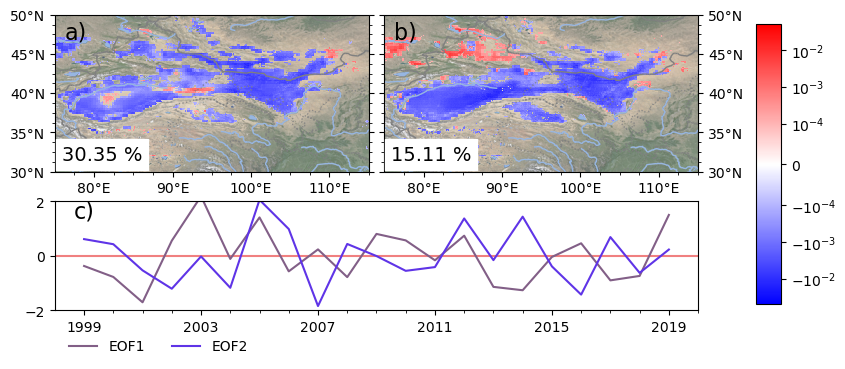

In [7]:
# fig,ax = plt.subplots(ncols=2, subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(12,7))
var_frac = pca_ems_detrended.varianceFraction(neigs=2)
fig = plt.figure(figsize=(8.3,4))
gs = fig.add_gridspec(ncols=2,nrows=2, height_ratios=[1,0.6],hspace=0.12, wspace=0.05)
# map_terrain_china(ax[0])
ax0 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
map_terrain_china(ax0)
ax0.tick_params(axis="y", which='both',right=True, left=True, labelleft=True, labelright=False)
plot_log_anomaly(eofs_detrend.sel(mode=0), linthresh=0.0001, vmin=-5e-2, vmax=5e-2,upper_bound=1e-4, ax=ax0,
                               lower_bound=-1e-4, cmap='bwr', add_labels=False, colorbar=False)
ax0.text(0.15,0.11, '{:1.2f} %'.format(var_frac.sel(mode=0).values*100), verticalalignment='center',horizontalalignment='center',
         transform=ax0.transAxes, fontsize=14, bbox=dict(facecolor='white',ec='white'))
ax1 = fig.add_subplot(gs[0,1],projection=ccrs.PlateCarree())
ax1.tick_params(axis="y", which='both',right=True, left=True, labelleft=False, labelright=True)

map_terrain_china(ax1)
ax1.text(0.149,0.11, '{:1.2f} %'.format(var_frac.sel(mode=1).values*100), verticalalignment='center',horizontalalignment='center',
         transform=ax1.transAxes, fontsize=14, bbox=dict(facecolor='white', ec='white'))
plot_log_anomaly(eofs_detrend.sel(mode=1), linthresh=0.0001, vmin=-5e-2, vmax=5e-2,upper_bound=1e-4, ax=ax1,
                               lower_bound=-1e-4, cmap='bwr', add_labels=False, colorbar=False)
ax2 = fig.add_subplot(gs[1,:])
ax2.plot(pcs.time.dt.year,pcs.sel(mode=0), label='EOF1')
ax2.plot(pcs.time.dt.year,pcs.sel(mode=1), label='EOF2')
ax2.set_ylim(-2,2)
ax2.set_xticks(pcs.time.dt.year[::4])
#ax2.legend(ncol=2)
cax = fig.add_axes([0.97,0.125,0.03,0.7])
norm=mpl.colors.SymLogNorm(linthresh=0.0001, linscale=1,vmin=-5e-2, vmax=5e-2,base=10)
fig.colorbar(cm.ScalarMappable(norm=norm,cmap='bwr'), cax=cax)
add_letter(np.array((ax0,ax1,ax2)),y=0.85)
l,h = ax2.get_legend_handles_labels()
ax2.xaxis.set_minor_locator(AutoMinorLocator(4))
ax2.axhline(y=0, color='lightcoral', linestyle='-', zorder=-10)
fig.legend(l,h,bbox_to_anchor=(0.25,0.02),loc='center', ncol=2, frameon=False)
plt.savefig('Emissions_EOF.pdf', bbox_inches='tight')


[]

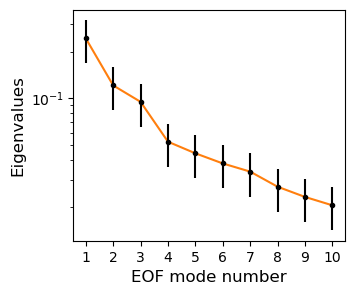

In [8]:
fig,ax = plt.subplots(figsize=(3.5,3))
eigs = pca_ems_detrended.eigenvalues(neigs=10)
errors = pca_ems_detrended.northTest(neigs=10,vfscaled=False)
ax.plot(eigs.mode+1,eigs,color='tab:orange')
ax.errorbar(eigs.mode+1,eigs,yerr=errors.values, fmt='.k', zorder=1000)
ax.set_xticks(eigs.mode+1)
ax.set_xlabel("EOF mode number")
ax.set_ylabel("Eigenvalues")
ax.semilogy()
# plt.savefig('../figs/EOF_north_test.pdf', bbox_inches='tight')

#### Which mode of the PCs correspond to what kind of emission pattern

In [9]:
weak_years_pc1, strong_years_pc1 = select_years_to_composite(pcs.sel(mode=0),4)
weak_years_pc2, strong_years_pc2 = select_years_to_composite(pcs.sel(mode=1),4)

In [10]:
ems_dset_y = ems_dset_y.assign(time=ems_dset_y.time.dt.year)

In [11]:
ems_positive_pc = ems_dset_y.sel(time=strong_years_pc2)
ems_positive_pc = ems_positive_pc.Emission.mean(dim='time',keep_attrs=True)
ems_positive_pc = ems_positive_pc/ems_positive_pc.mean(dim=['lon','lat'])

In [12]:
ems_negative_pc = ems_dset_y.sel(time=weak_years_pc2)
ems_negative_pc = ems_negative_pc.Emission.mean(dim='time')
ems_negative_pc = ems_negative_pc/ems_negative_pc.mean(dim=['lon','lat'])

Text(0.5, 1.0, 'Negative PC2')

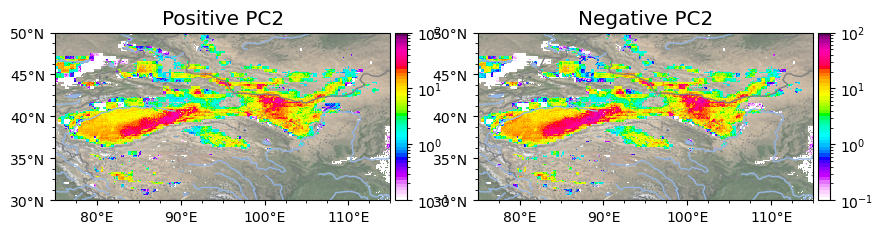

In [13]:
fig,ax = plt.subplots(ncols=2, subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(10,6))
map_terrain_china(ax[0])
mpl_base_map_plot_xr(ems_positive_pc,ax=ax[0], add_labels=False, vmax=1e2)
ax[0].set_title('Positive PC2')
map_terrain_china(ax[1])
mpl_base_map_plot_xr(ems_negative_pc,ax=ax[1], add_labels=False, vmax=1e2)
ax[1].set_title('Negative PC2')

In [14]:
ems_pc_anomal= ems_positive_pc-ems_negative_pc

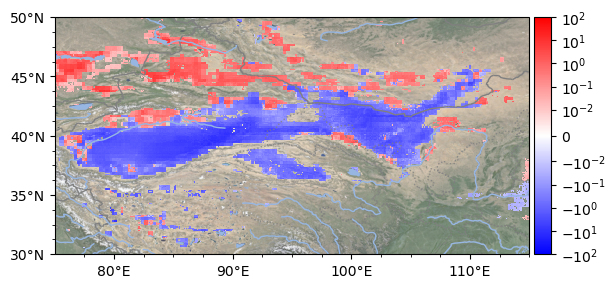

In [15]:
fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
map_terrain_china(ax)
plot_log_anomaly(ems_pc_anomal,linthresh=0.01, vmin=-1e2, vmax=1e2,upper_bound=1e-2, ax=ax,
                               lower_bound=-1e-2, cmap='bwr', add_labels=False)

## Circulation composite of positive EOF2 - negative EOF2

In [16]:
data_path = '../../data/data/downloads/intermediate_results/'
u_850_hpa=xr.open_dataset(data_path+'/era5.850hPa.u_component_of_wind.DJF.1979-2019.nc')
v_850_hpa=xr.open_dataset(data_path+'era5.850hPa.v_component_of_wind.DJF.1979-2019.nc')
mslp = xr.open_dataset(data_path+'era5.single_level.mean_sea_level_pressure.DJF.1979-2019.nc')

In [17]:
eof1_composite = mslp_wind_composite(mslp,u_850_hpa,v_850_hpa,weak_years_pc1,strong_years_pc1, '850','DJF')
eof2_composite = mslp_wind_composite(mslp,u_850_hpa,v_850_hpa,weak_years_pc2,strong_years_pc2, '850','DJF')

/opt/conda/envs/dust/lib/python3.11/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/opt/conda/envs/dust/lib/python3.11/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/opt/conda/envs/dust/lib/python3.11/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/opt/conda/envs/dust/lib/python3.11/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/opt/conda/envs/dust/lib/python3.11/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/opt/conda/envs/dust/lib/python3.11/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


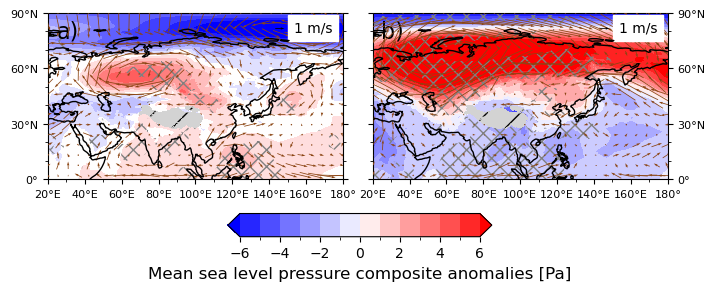

In [19]:
fig,ax = plt.subplots(ncols=2, subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(8,2.9))
plot_mslp_850hpa_composite(eof1_composite,ax=ax[0], x_qk=0.8, y_qk=.91, vector_scale=0.2,angles='uv', colorbar=False,U=1,
                          oro='../../data/data/downloads/ERA5_orography.nc')
# ax[0].set_title('EOF1 strong-weak')
plot_mslp_850hpa_composite(eof2_composite,ax=ax[1], x_qk=0.8, y_qk=.91, vector_scale=0.2,angles='uv', colorbar=False, U=1,
                          oro='../../data/data/downloads/ERA5_orography.nc')
# ax[1].set_title('EOF2 strong-weak')
add_letter(ax, y=0.85)
ax[1].tick_params(axis="y", which='both',right=True, left=True, labelleft=False, labelright=True, labelsize=8)
ax[0].tick_params(axis="y", which='both',right=True, left=True, labelleft=True, labelright=False, labelsize=8)
ax[0].tick_params(axis="x", which='both',bottom=True, top=False, labelbottom=True, labeltop=False, labelsize=8)
ax[1].tick_params(axis="x", which='both',bottom=True, top=False, labelbottom=True, labeltop=False, labelsize=8)
fig.subplots_adjust(wspace=0.1)
cmap = mpl.cm.bwr

cax = fig.add_axes([0.35,0.01,0.33,0.08])
fig.colorbar(mpl.cm.ScalarMappable(mpl.colors.BoundaryNorm(np.arange(-6,7,1),cmap.N, extend='both'), 
                                          cmap=cmap),cax=cax, extend='both', orientation='horizontal', 
            label='Mean sea level pressure composite anomalies [Pa]')
plt.savefig('EOF_emissions_composite.pdf',bbox_inches='tight')

In [21]:
data_path = '../../data/data/downloads/intermediate_results/'
u_850_hpa=xr.open_dataset(data_path+'/era5.850hPa.u_component_of_wind.MAM.1979-2019.nc')
v_850_hpa=xr.open_dataset(data_path+'era5.850hPa.v_component_of_wind.MAM.1979-2019.nc')
mslp = xr.open_dataset(data_path+'era5.single_level.mean_sea_level_pressure.MAM.1979-2019.nc')
eof1_composite = mslp_wind_composite(mslp,u_850_hpa,v_850_hpa,weak_years_pc1,strong_years_pc1, '850','MAM')
eof2_composite = mslp_wind_composite(mslp,u_850_hpa,v_850_hpa,weak_years_pc2,strong_years_pc2, '850','MAM')

/opt/conda/envs/dust/lib/python3.11/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/opt/conda/envs/dust/lib/python3.11/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/opt/conda/envs/dust/lib/python3.11/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/opt/conda/envs/dust/lib/python3.11/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/opt/conda/envs/dust/lib/python3.11/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/opt/conda/envs/dust/lib/python3.11/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


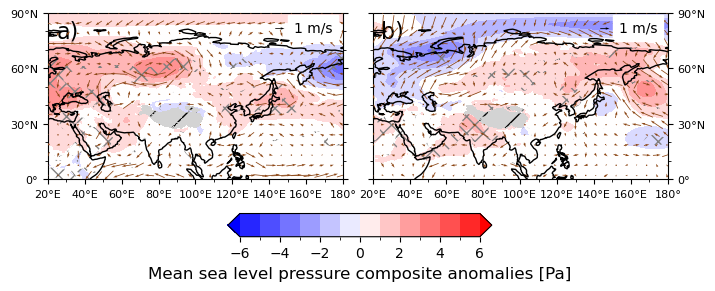

In [22]:
fig,ax = plt.subplots(ncols=2, subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(8,2.9))
plot_mslp_850hpa_composite(eof1_composite,ax=ax[0], x_qk=0.8, y_qk=.91, vector_scale=0.2,angles='uv', colorbar=False,U=1,
                          oro='../../data/data/downloads/ERA5_orography.nc')
# ax[0].set_title('EOF1 strong-weak')
plot_mslp_850hpa_composite(eof2_composite,ax=ax[1], x_qk=0.8, y_qk=.91, vector_scale=0.2,angles='uv', colorbar=False,U=1,
                          oro='../../data/data/downloads/ERA5_orography.nc')
# ax[1].set_title('EOF2 strong-weak')
add_letter(ax, y=0.85)
ax[1].tick_params(axis="y", which='both',right=True, left=True, labelleft=False, labelright=True, labelsize=8)
ax[0].tick_params(axis="y", which='both',right=True, left=True, labelleft=True, labelright=False, labelsize=8)
ax[0].tick_params(axis="x", which='both',bottom=True, top=False, labelbottom=True, labeltop=False, labelsize=8)
ax[1].tick_params(axis="x", which='both',bottom=True, top=False, labelbottom=True, labeltop=False, labelsize=8)
fig.subplots_adjust(wspace=0.1)
cmap = mpl.cm.bwr

cax = fig.add_axes([0.35,0.01,0.33,0.08])
fig.colorbar(mpl.cm.ScalarMappable(mpl.colors.BoundaryNorm(np.arange(-6,7,1),cmap.N, extend='both'), 
                                          cmap=cmap),cax=cax, extend='both', orientation='horizontal', 
            label='Mean sea level pressure composite anomalies [Pa]')
plt.savefig('EOF_emissions_composite_MAM.pdf',bbox_inches='tight')